Node coordinates (x, y):
[[ 0.          0.        ]
 [ 0.22222222  0.        ]
 [ 0.44444444  0.        ]
 [ 0.66666667  0.        ]
 [ 0.88888889  0.        ]
 [ 1.11111111  0.        ]
 [ 1.33333333  0.        ]
 [ 1.55555556  0.        ]
 [ 1.77777778  0.        ]
 [ 2.          0.        ]
 [ 0.          0.51282051]
 [ 0.22222222  0.51282051]
 [ 0.44444444  0.51282051]
 [ 0.66666667  0.51282051]
 [ 0.88888889  0.51282051]
 [ 1.11111111  0.51282051]
 [ 1.33333333  0.51282051]
 [ 1.55555556  0.51282051]
 [ 1.77777778  0.51282051]
 [ 2.          0.51282051]
 [ 0.          1.02564103]
 [ 0.22222222  1.02564103]
 [ 0.44444444  1.02564103]
 [ 0.66666667  1.02564103]
 [ 0.88888889  1.02564103]
 [ 1.11111111  1.02564103]
 [ 1.33333333  1.02564103]
 [ 1.55555556  1.02564103]
 [ 1.77777778  1.02564103]
 [ 2.          1.02564103]
 [ 0.          1.53846154]
 [ 0.22222222  1.53846154]
 [ 0.44444444  1.53846154]
 [ 0.66666667  1.53846154]
 [ 0.88888889  1.53846154]
 [ 1.11111111  1.53846154]
 [ 

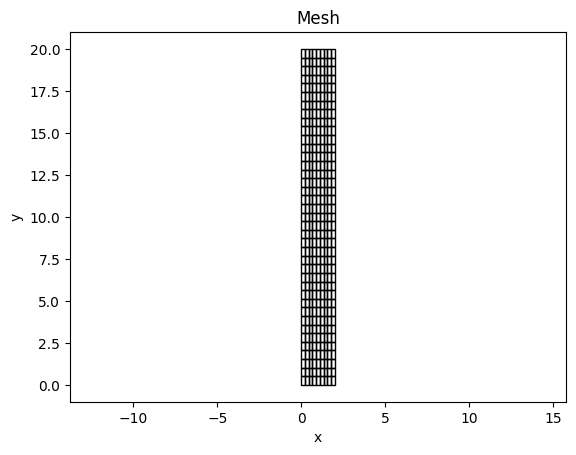

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from SSDpy.num.plates import plate12DOFs as plate
from scipy.interpolate import RegularGridInterpolator

# PROBLEM DEFINITION

# if Ly/Lx in {1, 2}, the code provides analytical solution for comparison
Lx, Ly = 2., 20.  # Floor dimensions [m]  
E = 200.e9   # Young's modulus [N/m^2]
e = 0.020    # Thickness [m]
nu = 0.3     # Poisson's ratio
q = 20000.    # Uniform load [N/m^2]
rho = 7850.   # Mass density, used for mass matrix and vibration analysis only [kg/m^3]

D = E * e**3 / (12 * (1 - nu**2))  # Flexural rigidity
mu = rho * e  # Mass per unit area

# Mesh definition
nX, nY = 10, 40  # Number of nodes
dx, dy = Lx / (nX - 1), Ly / (nY - 1)

x = np.linspace(0, Lx, nX)
y = np.linspace(0, Ly, nY)
X, Y = np.meshgrid(x, y)

# Nodes list
nodes = np.column_stack([X.flatten(), Y.flatten()])

# Element connectivity
elements = []
for i in range(nX - 1):
    for j in range(nY - 1):
        node1 = j * nX + i
        node2 = j * nX + (i + 1)
        node3 = (j + 1) * nX + i
        node4 = (j + 1) * nX + (i + 1)
        elements.append([node1, node2, node4, node3])

elements = np.array(elements)

# Display the nodes and elements
print("Node coordinates (x, y):")
print(nodes)

print("\nElement connectivity:")
print(elements)

# Plot the mesh
plt.figure()
for element in elements:
    coords = nodes[element]
    plt.fill(coords[:, 0], coords[:, 1], edgecolor='k', fill=False)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Mesh')
plt.show()

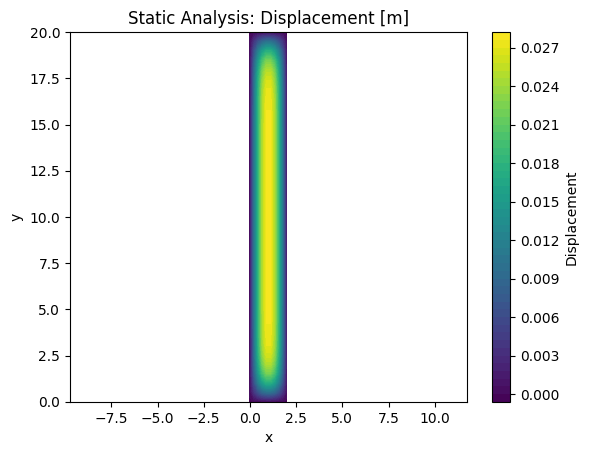

In [ ]:
# Assemble stiffness matrix
ndof = 3 * len(nodes)

Ktot = np.zeros((ndof, ndof))
Mtot = np.zeros((ndof, ndof))
ptot = np.zeros(ndof)
elements_idofs = []

a, b = dy / 2 , dx / 2

for element in elements:
    idofs = []
    for node in element:
        idofs.extend([3 * node + i for i in range(3)])
    elements_idofs.append(idofs)    
    
    Ke = plate.stiffness_12dof(a, b, D, nu)
    Me = plate.mass_12dof(a, b, mu)
    pe = plate.load_12dof(a, b, q)

    Ktot[np.ix_(idofs, idofs)] += Ke
    Mtot[np.ix_(idofs, idofs)] += Me
    ptot[idofs] += pe    

# Apply boundary conditions - use a penalty method
dKtot = np.diag(Ktot)
K_transl = 1000 * np.max(dKtot[::3])
K_rot = 1000 * np.max(dKtot[1::3])

bottom_edge = np.where(nodes[:, 1] == 0)[0]
top_edge = np.where(nodes[:, 1] == Ly)[0]
left_edge = np.where(nodes[:, 0] == 0)[0]
right_edge = np.where(nodes[:, 0] == Lx)[0]

supported_nodes = np.unique(np.concatenate([bottom_edge, top_edge, left_edge, right_edge]))
fixed_dofs_transl = 3 * supported_nodes

for dof in fixed_dofs_transl:
    Ktot[dof, dof] += K_transl

# run static analysis
U = np.linalg.solve(Ktot, ptot)
u = U[::3].reshape((nY, nX))

plt.figure()
plt.contourf(x, y, u, levels=50, cmap='twilight')
plt.colorbar(label='Displacement')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Static Analysis: Displacement [m]')
plt.axis('equal')
plt.show()

In [9]:
# Calculate the displacement at a specific point by interpolation in x, y, u
x0=Lx/2
y0=Ly/2
interp_func = RegularGridInterpolator((x, y), u.T)
u0 = interp_func((x0,y0))
print(f'FE model : Displacement at ({x0}, {y0}) = {u0:.4f} m')

if Lx/Ly == 1:
    coef = 0.00406 # Timoshenko beam theory coefficient (b/a = 1)
elif Ly/Lx == 2:
    coef = 0.01013 # Timoshenko beam theory coefficient (b/a = 2)
else:
    coef = np.nan

u0_theory = coef * q * Lx**4 / D
print(f'Table (Timoshenko) : Displacement at ({x0}, {y0}) = {u0_theory:.4f} m')

FE model : Displacement at (1.0, 10.0) = 0.0277 m
Table (Timoshenko) : Displacement at (1.0, 10.0) = nan m


In [10]:
# Compute moments
Mx = np.zeros((len(elements), 4))
My = np.zeros((len(elements), 4))
Mxy= np.zeros((len(elements), 4))

for i, element in enumerate(elements):
    idofs = elements_idofs[i]
    coefMoments = plate.moment_coefs(a, b, nu, D)
    u = U[idofs]
    M1, M2, M3, M4 = coefMoments[0] @ u, coefMoments[1] @ u, coefMoments[2] @ u, coefMoments[3] @ u
    Mx[i, :] = np.array((M1[0], M2[0], M3[0], M4[0]))
    My[i, :] = np.array((M1[1], M2[1], M3[1], M4[1]))
    Mxy[i, :] = np.array((M1[2], M2[2], M3[2], M4[2]))

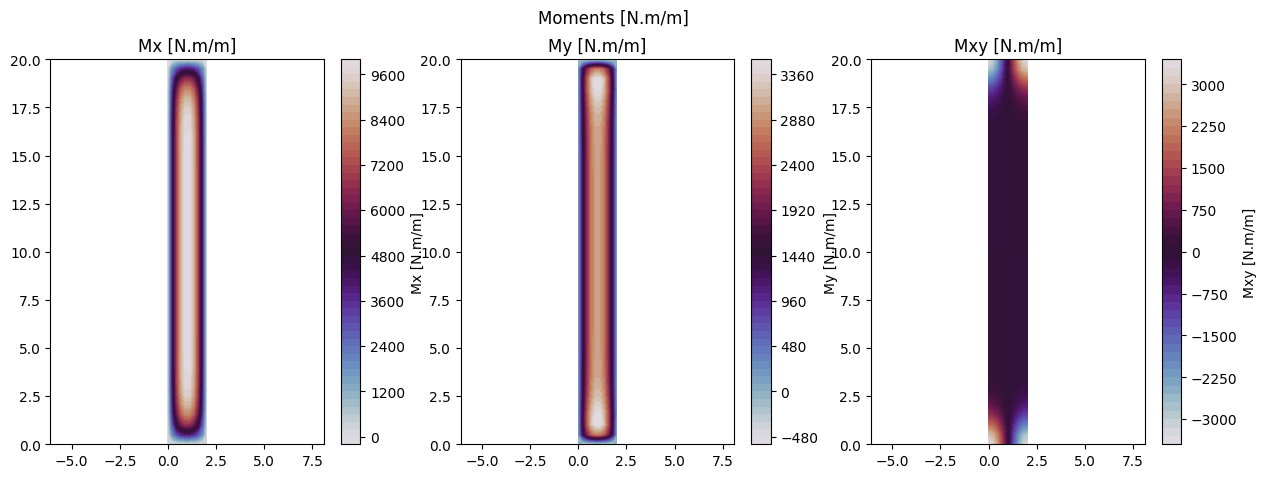

In [11]:
# Plot moments
Mxplot, Myplot, Mxyplot = np.zeros((len(x), len(y))), np.zeros((len(x), len(y))), np.zeros((len(x), len(y)))
xx, yy = np.meshgrid(x, y)
for i in range(len(x)):
    for j in range(len(y)):
        indx = np.where((nodes[elements[:, :], 0] == x[i]) & (nodes[elements[:, :], 1] == y[j]))
        Mxplot[i, j] = np.mean(Mx[indx])
        Myplot[i, j] = np.mean(My[indx])
        Mxyplot[i, j] = np.mean(Mxy[indx])
rows, cols = 1, 3
fig, axs = plt.subplots(rows, cols, figsize=(15, 5))
fig.suptitle('Moments [N.m/m]')
axs[0].set_title('Mx [N.m/m]')
axs[1].set_title('My [N.m/m]')
axs[2].set_title('Mxy [N.m/m]')
axs[0].contourf(xx, yy, Mxplot.T, levels=50, cmap='twilight')
axs[1].contourf(xx, yy, Myplot.T, levels=50, cmap='twilight')
axs[2].contourf(xx, yy, Mxyplot.T, levels=50, cmap='twilight')
axs[0].axis('equal')
axs[1].axis('equal')
axs[2].axis('equal')
# colorbar
fig.colorbar(axs[0].collections[0], ax=axs[0], label='Mx [N.m/m]')
fig.colorbar(axs[1].collections[0], ax=axs[1], label='My [N.m/m]')
fig.colorbar(axs[2].collections[0], ax=axs[2], label='Mxy [N.m/m]')

In [ ]:
# Calculate the bending moment at a specific point by interpolation in x, y, u
x0=Lx/2
y0=Ly/2
interp_func_Mx = RegularGridInterpolator((x, y), Mxplot)
interp_func_My = RegularGridInterpolator((x, y), Myplot)
Mx0 = interp_func_Mx((x0,y0))
My0 = interp_func_My((x0,y0))
print ('Comparison of moments at the center of the plate:')
print(f'  FE model : Moment Mx at ({x0}, {y0}) = {Mx0:.4f} N.m/m')
print(f'  FE model : Moment My at ({x0}, {y0}) = {My0:.4f} N.m/m')

if Ly/Lx == 1:
    coefx = 0.0479 # Timoshenko beam theory coefficient (b/a = 1)
    coefy = 0.0479 # Timoshenko beam theory coefficient (b/a = 1)
elif Ly/Lx == 2:
    coefx = 0.1017 # Timoshenko beam theory coefficient (b/a = 2)
    coefy = 0.0464 # Timoshenko beam theory coefficient (b/a = 2)
else:
    coefx = np.nan
    coefy = np.nan

Mx0_theory = coefx * q * Lx**2
My0_theory = coefy * q * Lx**2

print(f'  Table (Timoshenko) : Moment Mx at ({x0}, {y0}) = {Mx0_theory:.4f} N.m/m')
print(f'  Table (Timoshenko) : Moment My at ({x0}, {y0}) = {My0_theory:.4f} N.m/m')
print(f'  Strip theory : Moment Mx at ({x0}, {y0}) = {0.125 * q * Lx**2:.4f} N.m/m')
print(f'  Strip theory : Moment My at ({x0}, {y0}) = {0.125 * nu * q * Lx**2:.4f} N.m/m')


Comparison of moments at the center of the plate:
  FE model : Moment Mx at (1.0, 10.0) = 9876.5381 N.m/m
  FE model : Moment My at (1.0, 10.0) = 2962.9706 N.m/m
  Table (Timoshenko) : Moment Mx at (1.0, 10.0) = nan N.m/m
  Table (Timoshenko) : Moment My at (1.0, 10.0) = nan N.m/m
  Strip theory : Moment Mx at (1.0, 10.0) = 10000.0000 N.m/m
  Strip theory : Moment My at (1.0, 10.0) = 3000.0000 N.m/m


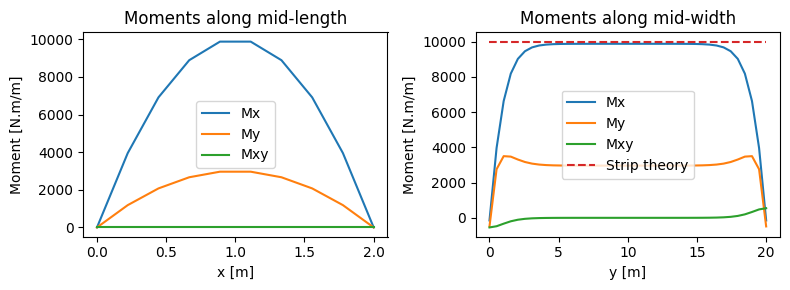

In [ ]:
# plot mid-length Mx, My, Mxy
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].plot(x, Mxplot[:,int(nY/2)], label='Mx')
ax[0].plot(x, Myplot[:,int(nY/2)], label='My')
ax[0].plot(x, Mxyplot[:,int(nY/2)], label='Mxy')
ax[0].set_title('Moments along mid-length')
ax[0].set_xlabel('x [m]')
ax[0].set_ylabel('Moment [N.m/m]')
ax[0].legend()
ax[1].plot(y, Mxplot[int(nX/2), :], label='Mx')
ax[1].plot(y, Myplot[int(nX/2), :], label='My')
ax[1].plot(y, Mxyplot[int(nX/2), :], label='Mxy')
ax[1].plot(y, np.ones_like(y) * 0.125 * q * Lx**2, label='Strip theory', linestyle='--')
ax[1].set_title('Moments along mid-width')
ax[1].set_xlabel('y [m]')
ax[1].set_ylabel('Moment [N.m/m]')
ax[1].legend()
plt.tight_layout()
plt.show()

In [24]:
Mxplot.shape
nX, nY

(10, 40)